# Explore training dataset

In [4]:
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from glob import glob
from PIL import Image
import seaborn as sns
import math
import random
import xarray as xr
from torch.masked import masked_tensor, as_masked_tensor

In [2]:
data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsetsv1/train'
path_list = glob(f'{data_dir}/ASO_50M_SD*.nc')

In [3]:
norm_dict = {'aso_sd':[0, 24.9],
             'vv':[0, 13523.8],
             'vh':[0, 43.2],
             'AOT':[0, 572.1],
             'coastal':[0, 23459.1],
             'blue':[0, 23004.1],
             'green':[0, 26440.1],
             'red':[0, 21576.1],
             'red_edge1':[0, 20796.1],
             'red_edge2':[0, 20432.1],
             'red_edge3':[0, 20149.1],
             'nir':[0, 21217.1],
             'water_vapor':[0, 18199.1],
             'swir1':[0, 17549.1],
             'swir2':[0, 17314.1],
             'scene_class_map':[0, 15],
             'water_vapor_product':[0, 6517.5],
             'elevation':[-100, 9000]}

In [4]:
def calc_norm(tensor, minmax_list):
    normalized = (tensor-minmax_list[0])/(minmax_list[1]-minmax_list[0])
    return normalized

In [25]:
# define dataset 
class dataset(torch.utils.data.Dataset):
    def __init__(self, path_list, norm_dict, norm=True):
        self.path_list = path_list
        self.norm_dict = norm_dict
        self.norm = norm
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.path_list)
        return self.filelength
    
    #load images
    def __getitem__(self,idx):
        ds = xr.open_dataset(self.path_list[idx])
        #ds = ds.coarsen(x = 6, boundary = 'trim').mean().coarsen(y = 6, boundary = 'trim').mean()
        # convert to tensors
        aso_sd = torch.from_numpy(ds.aso_sd.values)
        snowon_vv = torch.from_numpy(ds.snowon_vv.values)
        snowon_vh = torch.from_numpy(ds.snowon_vh.values)
        snowoff_vv = torch.from_numpy(ds.snowoff_vv.values)
        snowoff_vh = torch.from_numpy(ds.snowoff_vh.values)
        snowon_vv_mean = torch.from_numpy(ds.snowon_vv_mean.values)
        snowon_vh_mean = torch.from_numpy(ds.snowon_vh_mean.values)
        snowoff_vv_mean = torch.from_numpy(ds.snowoff_vv_mean.values)
        snowoff_vh_mean = torch.from_numpy(ds.snowoff_vh_mean.values)
        aerosol_optical_thickness = torch.from_numpy(ds.AOT.values)
        coastal_aerosol = torch.from_numpy(ds.B01.values)
        blue = torch.from_numpy(ds.B02.values)
        green = torch.from_numpy(ds.B03.values)
        red = torch.from_numpy(ds.B04.values)
        red_edge1 = torch.from_numpy(ds.B05.values)
        red_edge2 = torch.from_numpy(ds.B06.values)
        red_edge3 = torch.from_numpy(ds.B07.values)
        nir = torch.from_numpy(ds.B08.values)
        water_vapor = torch.from_numpy(ds.B09.values)
        swir1 = torch.from_numpy(ds.B11.values)
        swir2 = torch.from_numpy(ds.B12.values)
        scene_class_map = torch.from_numpy(ds.SCL.values)
        water_vapor_product = torch.from_numpy(ds.WVP.values)
        fcf = torch.from_numpy(ds.fcf.values)
        elevation = torch.from_numpy(ds.elevation.values)
        aso_gap_map = torch.from_numpy(ds.aso_gap_map.values)
        rtc_gap_map = torch.from_numpy(ds.rtc_gap_map.values)
        rtc_mean_gap_map = torch.from_numpy(ds.rtc_mean_gap_map.values)
            
        # normalize layers (except gap maps and fcf)
        if self.norm == True:
            aso_sd = calc_norm(aso_sd, self.norm_dict['aso_sd'])
            snowon_vv = calc_norm(snowon_vv, self.norm_dict['vv'])
            snowon_vh = calc_norm(snowon_vh, self.norm_dict['vh'])
            snowoff_vv = calc_norm(snowoff_vv, self.norm_dict['vv'])
            snowoff_vh = calc_norm(snowoff_vh, self.norm_dict['vh'])
            snowon_vv_mean = calc_norm(snowon_vv_mean, self.norm_dict['vv'])
            snowon_vh_mean = calc_norm(snowon_vh_mean, self.norm_dict['vh'])
            snowoff_vv_mean = calc_norm(snowoff_vv_mean, self.norm_dict['vv'])
            snowoff_vh_mean = calc_norm(snowoff_vh_mean, self.norm_dict['vh'])
            aerosol_optical_thickness = calc_norm(aerosol_optical_thickness, self.norm_dict['AOT'])
            coastal_aerosol = calc_norm(coastal_aerosol, self.norm_dict['coastal'])
            blue = calc_norm(blue, self.norm_dict['blue'])
            green = calc_norm(green, self.norm_dict['green'])
            red = calc_norm(red, self.norm_dict['red'])
            red_edge1 = calc_norm(red_edge1, self.norm_dict['red_edge1'])
            red_edge2 = calc_norm(red_edge2, self.norm_dict['red_edge2'])
            red_edge3 = calc_norm(red_edge3, self.norm_dict['red_edge3'])
            nir = calc_norm(nir, self.norm_dict['nir'])
            water_vapor = calc_norm(water_vapor, self.norm_dict['water_vapor'])
            swir1 = calc_norm(swir1, self.norm_dict['swir1'])
            swir2 = calc_norm(swir2, self.norm_dict['swir2'])
            scene_class_map = calc_norm(scene_class_map, self.norm_dict['scene_class_map'])
            water_vapor_product = calc_norm(water_vapor_product, self.norm_dict['water_vapor_product'])
            elevation = calc_norm(elevation, self.norm_dict['elevation'])
         
        # return only selected bands, for now
        return aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, nir, swir1, swir2, fcf, elevation, aso_gap_map, rtc_gap_map

In [26]:
# create dataloaders
train_data = dataset(path_list, norm_dict, norm=True)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=1, shuffle=True)

In [7]:
# # dataset min and max for normalization
# norm_dict = {}
# for i, outputs in enumerate(train_loader):
#     if (i+1)%1000 == 0: 
#         print(f'loop {i+1}/{train_data.filelength}')
#     for j, item in enumerate(outputs):
#         if i == 0:
#             norm_dict[j] = [item.min(), item.max()]
#         if item.max() > norm_dict[j][1]:
#             norm_dict[j][1] = item.max().item()
#         if item.min() < norm_dict[j][0] and not item.min() == 0:
#             norm_dict[j][0] = item.min().item()

In [8]:
# sns.set_theme()
# # plot normalized training inputs 
# num_samples = 1

# for i, (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, nir, swir1, swir2, fcf, elevation, aso_gap_map, rtc_gap_map) in enumerate(train_loader):
#     if i < num_samples:
#             f, ax = plt.subplots(3, 4, figsize=(10,8), sharey=True, sharex=True)
#             ax[0, 0].imshow(aso_sd.squeeze(), cmap='Blues', vmin=0, vmax=1, interpolation='none') 
#             ax[0, 0].set_title('ASO snow depths')
#             ax[0, 1].imshow(elevation.squeeze(), cmap='viridis', interpolation='none') 
#             ax[0, 1].set_title('Copernicus DEM')
#             ax[0, 2].imshow(fcf.squeeze(), cmap='Greens', vmin=0, vmax=1, interpolation='none') 
#             ax[0, 2].set_title('fractional forest cover')
#             norm_max = np.max([green.max(), red.max(), blue.max()])
#             ax[0, 3].imshow(torch.cat((red[:, :, :, None]/norm_max, green[:, :, :, None]/norm_max, blue[:, :, :, None]/norm_max), 3).squeeze(), interpolation='none') 
#             ax[0, 3].set_title('true color image')
#             ax[1, 0].imshow(snowon_vv.squeeze(), cmap='Greys_r', vmin=0, vmax=0.3, interpolation='none') 
#             ax[1, 0].set_title('S1 snow-on vv')
#             ax[1, 1].imshow(snowon_vh.squeeze(), cmap='Greys_r', vmin=0, vmax=0.1, interpolation='none') 
#             ax[1, 1].set_title('S1 snow-on vh')
#             ax[1, 2].imshow(snowoff_vv.squeeze(), cmap='Greys_r', vmin=0, vmax=0.3, interpolation='none') 
#             ax[1, 2].set_title('S1 snow-off vv')
#             ax[1, 3].imshow(snowoff_vh.squeeze(), cmap='Greys_r', vmin=0, vmax=0.1, interpolation='none') 
#             ax[1, 3].set_title('S1 snow-off vh')
#             ax[2, 0].imshow(snowon_vh.squeeze()/snowon_vv.squeeze(), cmap='Purples', vmin=0, vmax=1, interpolation='none') 
#             ax[2, 0].set_title('snow-on vh/vv')
#             ax[2, 1].imshow(snowoff_vh.squeeze()/snowoff_vv.squeeze(), cmap='Purples', vmin=0, vmax=1, interpolation='none') 
#             ax[2, 1].set_title('snow-off vh/vv')
#             ax[2, 2].imshow((snowon_vh.squeeze()/snowon_vv.squeeze()-snowoff_vh.squeeze()/snowoff_vv.squeeze())+0.1, cmap='RdBu', vmin=-0.3, vmax=0.3, interpolation='none') 
#             ax[2, 2].set_title('snow-on vh/vv - snow-off vh/vv')
#             ax[2, 3].imshow(aso_gap_map.squeeze()+rtc_gap_map.squeeze(), cmap='Purples', interpolation='none') 
#             ax[2, 3].set_title('aso and rtc gaps')
#             ax[0, 0].set_aspect('equal')
            
#             f.tight_layout()
#     else: 
#         break

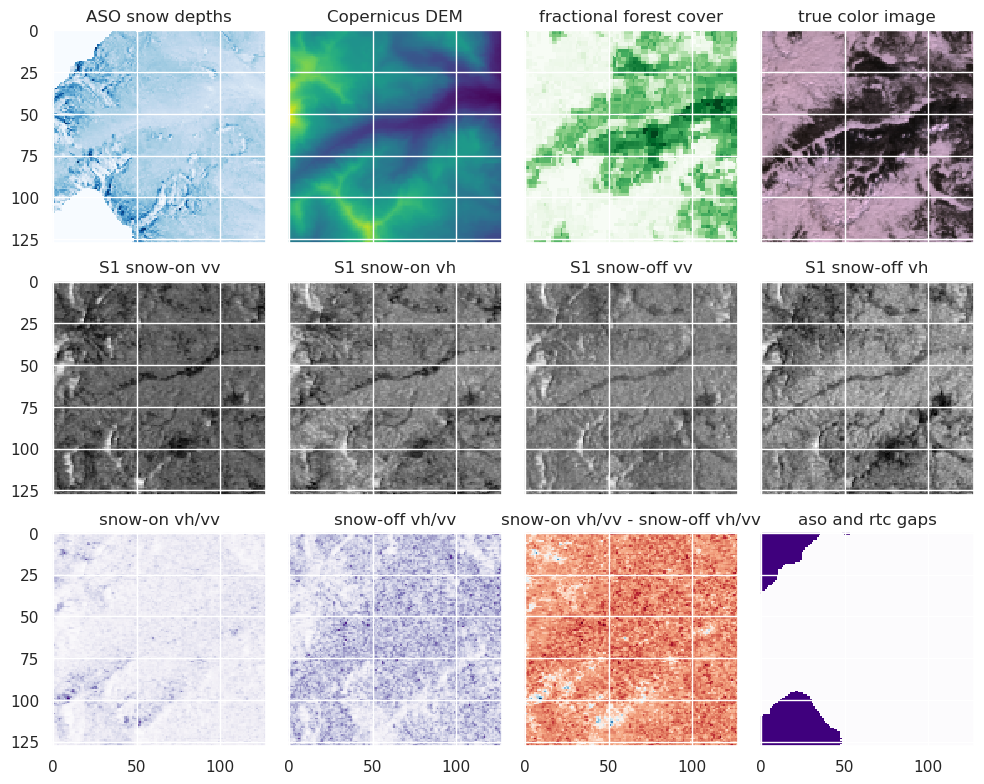

In [39]:
sns.set_theme()
# plot normalized training inputs 
num_samples = 1

for i, (aso_sd, snowon_vv, snowon_vh, snowoff_vv, snowoff_vh, blue, green, red, nir, swir1, swir2, fcf, elevation, aso_gap_map, rtc_gap_map) in enumerate(train_loader):
    if i < num_samples:
            f, ax = plt.subplots(3, 4, figsize=(10,8), sharey=True, sharex=True)
            ax[0, 0].imshow(aso_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.2, interpolation='none') 
            ax[0, 0].set_title('ASO snow depths')
            ax[0, 1].imshow(elevation.squeeze(), cmap='viridis', interpolation='none') 
            ax[0, 1].set_title('Copernicus DEM')
            ax[0, 2].imshow(fcf.squeeze(), cmap='Greens', interpolation='none') 
            ax[0, 2].set_title('fractional forest cover')
            norm_max = np.max([green.max(), red.max(), blue.max()])
            ax[0, 3].imshow(torch.cat((red[:, :, :, None]/norm_max, green[:, :, :, None]/norm_max, blue[:, :, :, None]/norm_max), 3).squeeze(), interpolation='none') 
            ax[0, 3].set_title('true color image')
            ax[1, 0].imshow(np.log(snowon_vv.squeeze()), cmap='Greys_r', interpolation='none') 
            ax[1, 0].set_title('S1 snow-on vv')
            ax[1, 1].imshow(np.log(snowon_vh.squeeze()), cmap='Greys_r', interpolation='none') 
            ax[1, 1].set_title('S1 snow-on vh')
            ax[1, 2].imshow(np.log(snowoff_vv.squeeze()), cmap='Greys_r', interpolation='none') 
            ax[1, 2].set_title('S1 snow-off vv')
            ax[1, 3].imshow(np.log(snowoff_vh.squeeze()), cmap='Greys_r', interpolation='none') 
            ax[1, 3].set_title('S1 snow-off vh')
            ax[2, 0].imshow(snowon_vh.squeeze()/snowon_vv.squeeze(), cmap='Purples', interpolation='none') 
            ax[2, 0].set_title('snow-on vh/vv')
            ax[2, 1].imshow(snowoff_vh.squeeze()/snowoff_vv.squeeze(), cmap='Purples', interpolation='none') 
            ax[2, 1].set_title('snow-off vh/vv')
            ax[2, 2].imshow((snowon_vh.squeeze()/snowon_vv.squeeze()-snowoff_vh.squeeze()/snowoff_vv.squeeze())+0.1, cmap='RdBu', interpolation='none') 
            ax[2, 2].set_title('snow-on vh/vv - snow-off vh/vv')
            ax[2, 3].imshow(aso_gap_map.squeeze()+rtc_gap_map.squeeze(), cmap='Purples', interpolation='none') 
            ax[2, 3].set_title('aso and rtc gaps')
            ax[0, 0].set_aspect('equal')
            
            f.tight_layout()
    else: 
        break